본 강좌에서는 간단한 컨볼루션 신경망 모델을 만들어봅니다. 늘 그렇듯이 다음과 같은 순서로 진행하겠습니다.

1. 문제 정의하기
1. 데이터셋 준비하기
1. 모델 구성하기
1. 모델 엮기
1. 모델 학습시키기
1. 모델 사용하기

---

### 문제 정의하기

좋은 예제와 그와 관련된 데이터셋도 공개된 것이 많이 있지만, 직접 문제를 정의하고 데이터를 만들어보는 것도 처럼 딥러닝을 접하시는 분들에게는 크게 도움이 될 것 같습니다. 컨볼루션 신경망 모델에 적합한 문제는 이미지 기반의 분류입니다. 따라서 우리는 직접 손으로 삼각형, 사각형, 원을 그려 이미지로 저장한 다음 이를 분류해보는 모델을 만들어보겠습니다. 문제 형태와 입출력을 다음과 같이 정의해봅니다.
* 문제 형태 : 다중 클래스 분류
* 입력 : 손으로 그린 삼각형, 사각형, 원 이미지
* 출력 : 삼각형, 사각형, 원일 확률을 나타내는 벡터

---

### 데이터셋 준비하기

손으로 그린 삼각형, 사각형, 원 이미지를 만들기 위해서는 여러가지 방법이 있을 수 있겠네요. 테블릿을 이용할 수도 있고, 종이에 그려서 사진으로 찍을 수도 있습니다. 저는 그림 그리는 툴을 이용해서 만들어봤습니다. 이미지 사이즈는 24 x 24 정도로 해봤습니다. 

![data](http://tykimos.github.com/Keras/warehouse/2017-3-8_CNN_Getting_Started_1.png)

모양별로 20개 정도를 만들어서 15개를 훈련에 사용하고, 5개를 테스트에 사용해보겠습니다. 이미지는 png나 jpg로 저장합니다. 실제로 데이터셋이 어떻게 구성되어 있는 지 모른 체 튜토리얼을 따라하거나 예제 코드를 실행시키다보면 결과는 잘 나오지만 막상 실제 문제에 적용할 때 막막해질 때가 있습니다. 

![data](http://tykimos.github.com/Keras/warehouse/2017-3-8_CNN_Getting_Started_2.png)


In [1]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        'warehouse/handwriting_shape/train',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical')

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory(
        'warehouse/handwriting_shape/validation',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical')

Found 60 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


Using Theano backend.


In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Next we need to load the MNIST dataset and reshape it so that it is suitable for use training a CNN. In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [channels][width][height]. In the case of RGB, the first dimension channels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In the case of MNIST where the channels values are gray scale, the pixel dimension is set to 1.

---

### 모델 구성하기

Next we define our neural network model. Convolutional neural networks are more complex than standard Multilayer Perceptrons, so we will start by using a simple structure to begin with that uses all of the elements for state-of-the-art results. Below summarizes the network architecture.
1. The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, which with the size of 5 ⇥ 5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above.
2. Next we define a pooling layer that takes the maximum value called MaxPooling2D. It is configured with a pool size of 2 ⇥ 2.
3. The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
4. Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
5. Next a fully connected layer with 128 neurons and rectifier activation function is used.
6. Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.
As before, the model is trained using logarithmic loss and the ADAM gradient descent algorithm. A depiction of the network structure is provided below.

In [3]:
# create model
model = Sequential()
model.add(Convolution2D(12, 3, 3, border_mode='same', input_shape=(3, 24, 24), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(2, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(3, 2, 2, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

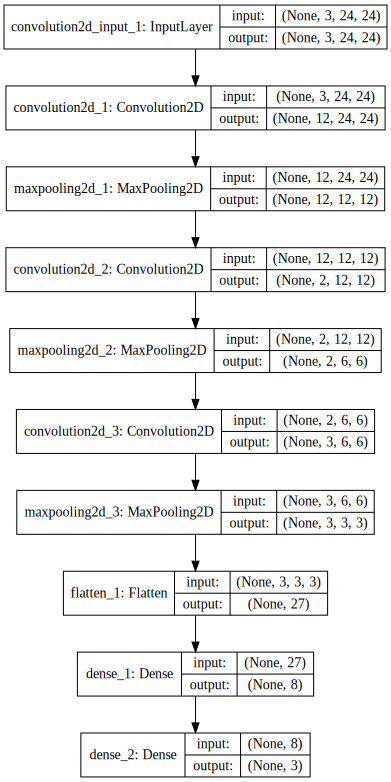

In [4]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

![model](http://tykimos.github.com/Keras/warehouse/2017-3-8_CNN_Getting_Started_3.png)

### 모델 엮기

컴파일 시에 정의해야하는 것들
- 가중치 세트를 평가하는 데 사용할 손실함수(loss function)
 - binary_crossentropy : 이진 분류를 위한 logarithmic loss
- 네트워크의 다른 가중치를 검객하는 데 사용되는 최적화 알고리즘
 - adam : 효율적인 경사 하강법(gradient descent) 알고리즘
- 학습과정에서 수집하기 싶은 측정 기준

In [5]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 모델 학습시키기

- nb_epoch : 데이터셋에 대한 반복 횟수
- batch_size : 네트워크에서 가중치 개갱신 전에 평가되는 인스턴스의 수

In [6]:
# Fit the model
model.fit_generator(
        train_generator,
        samples_per_epoch=60,
        nb_epoch=100,
        validation_data=validation_generator,
        nb_val_samples=15)

Epoch 1/100
60/60 [==============================] - 0s - loss: 6.9580 - acc: 0.4333 - val_loss: 8.7339 - val_acc: 0.3333
Epoch 2/100
60/60 [==============================] - 0s - loss: 5.8462 - acc: 0.5333 - val_loss: 8.2938 - val_acc: 0.2000
Epoch 3/100
60/60 [==============================] - 0s - loss: 5.4461 - acc: 0.6333 - val_loss: 8.4427 - val_acc: 0.2000
Epoch 4/100
60/60 [==============================] - 0s - loss: 5.3794 - acc: 0.6667 - val_loss: 8.4586 - val_acc: 0.2667
Epoch 5/100
60/60 [==============================] - 0s - loss: 5.3751 - acc: 0.6667 - val_loss: 8.4383 - val_acc: 0.2667
Epoch 6/100
60/60 [==============================] - 0s - loss: 5.3747 - acc: 0.6667 - val_loss: 8.4028 - val_acc: 0.2667
Epoch 7/100
60/60 [==============================] - 0s - loss: 5.3744 - acc: 0.6667 - val_loss: 8.3748 - val_acc: 0.2667
Epoch 8/100
60/60 [==============================] - 0s - loss: 5.3742 - acc: 0.6667 - val_loss: 8.3513 - val_acc: 0.2667
Epoch 9/100
60/60 [=====

In [7]:
# evaluate

scores = model.evaluate_generator(
            validation_generator, 
            val_samples = 15)

print("")
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

print("")

output = model.predict_generator(
            validation_generator, 
            val_samples = 15)

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print(output)


acc: 26.67%

[[0.000 0.042 0.958]
 [0.000 0.076 0.924]
 [0.000 1.000 0.000]
 [0.000 0.005 0.995]
 [0.000 0.097 0.903]
 [0.000 0.002 0.998]
 [0.000 1.000 0.000]
 [0.000 1.000 0.000]
 [0.000 0.000 1.000]
 [0.000 0.000 1.000]
 [0.000 1.000 0.000]
 [0.000 0.995 0.005]
 [0.000 0.000 1.000]
 [0.000 1.000 0.000]
 [0.000 0.967 0.033]]


---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/Keras/2017/01/27/Keras_Lecture_Plan/)
* 이전 : [딥러닝 기본 실습/다층 퍼셉트론 모델 만들어보기](https://tykimos.github.io/Keras/2017/02/04/MLP_Getting_Started/)
* 다음 : [딥러닝 기본 실습/오토인코더 모델 만들어보기](https://tykimos.github.io/Keras/2017/02/04/AutoEncoder_Getting_Started/)